# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [54]:
# These libraries may be useful to you

import nltk
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')



In [55]:
# add any additional libaries you need here


### Add supplemental stopwords per runtime warning

In [56]:
# adding two stopwords that were generated from tokenizing stopwords but not initially included in stopwords
# (runtime warning from vectorizer function)

stopwords.add("ll")
stopwords.add("ve")

### Topic display function

In [57]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [58]:
# categories of articles in Brown corpus

# added the download command
nltk.download('brown')

brown.categories()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\drzag\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [59]:
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [60]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

print(df.shape)
df.tail(5)

(166, 3)


,category,id,text
161,hobbies,ce32,"Throughout history , the man who showed superi..."
162,hobbies,ce33,Sixty miles north of New York City where the w...
163,hobbies,ce34,"In the period since the end of World War 2 , -..."
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...
165,hobbies,ce36,There comes a time in the lives of most of us ...


In [61]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))
df.tail(5)

,category,id,text,char_len,word_len
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272
165,hobbies,ce36,There comes a time in the lives of most of us ...,11682,2232


<AxesSubplot:xlabel='category'>

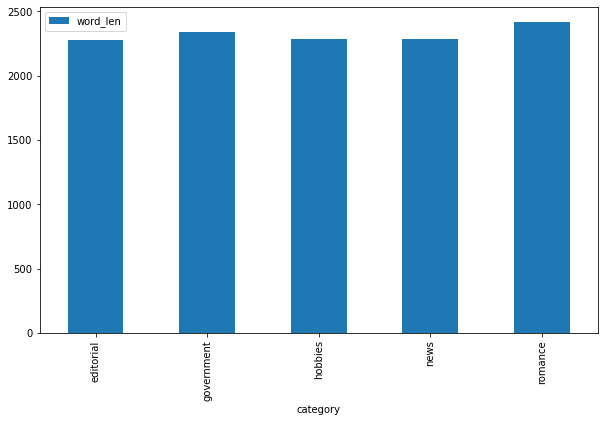

In [62]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [63]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)

count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
print(count_text_vectors.shape)
count_text_vectors

(166, 4939)


<166x4939 sparse matrix of type '<class 'numpy.int64'>'
	with 72452 stored elements in Compressed Sparse Row format>

Let's take a look at the actual elements in the sparse matrix:

In [64]:
pd.DataFrame.sparse.from_spmatrix(count_text_vectors).tail(5)

,0,1,2,3,4,5,6,7,8,9,...,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938
161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
162,0,2,0,0,0,0,0,0,1,2,...,0,0,0,3,0,0,0,0,0,0
163,0,0,4,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,8,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
165,11,0,2,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
print(tfidf_text_vectors.shape)
tfidf_text_vectors

(166, 4939)


<166x4939 sparse matrix of type '<class 'numpy.float64'>'
	with 72452 stored elements in Compressed Sparse Row format>

In [66]:
pd.DataFrame.sparse.from_spmatrix(tfidf_text_vectors).tail(5)

,0,1,2,3,4,5,6,7,8,9,...,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938
161,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.011308,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
162,0.000000,0.027694,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.018711,0.034501,...,0.0,0.0,0.0,0.04494,0.0,0.0,0.0,0.0,0.0,0.0
163,0.000000,0.000000,0.037145,0.012368,0.0,0.000000,0.022478,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
164,0.000000,0.083169,0.010015,0.013338,0.0,0.012361,0.024242,0.0,0.000000,0.012951,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
165,0.289612,0.000000,0.021754,0.000000,0.0,0.026850,0.000000,0.0,0.015257,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: "count_text_vectors" is a sparse matrix containing the actual raw count of tokens that appear in the entire corpus of 166 documents, one row (vectorized tokens) per document. It can be converted to a DataFrame to observe the values.  "tfidf_text_vectors" is a sparse matrix containing the frequency-adjusted (TF-IDF algorithm) token vectors.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [67]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\drzag\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


## Percentages for Each Topic

In [68]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100

array([18.16274915, 25.96062775, 29.55441741, 14.30338276, 12.01882294])

In [69]:
#Change to non-deprecated function:
#display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

# Map most likely known topics to new topics:
# Editorial 02
# Government 00
# Hobbies 04
# News 01
# Romance 03


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.89)
  didn (0.46)
  thought (0.42)
  man (0.38)
  don (0.35)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.63)
  mr (0.79)
  said (0.63)
  miss (0.53)
  car (0.51)

Topic 04
  game (1.02)
  league (0.75)
  ball (0.73)
  baseball (0.71)
  team (0.67)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [70]:
X_vecs = nmf_text_model.transform(tfidf_text_vectors)

In [71]:
# Get the top predicted topic
pred_topics = [np.argsort(row)[::-1][0] for row in X_vecs]

In [72]:
# Add to the df
df['pred_topic_num'] = pred_topics
df.tail(10)

,category,id,text,char_len,word_len,pred_topic_num
156,hobbies,ce27,Knowing specifically what the many feed additi...,12565,2323,2
157,hobbies,ce28,Marketing in the new decade will be no picnic ...,13290,2291,2
158,hobbies,ce29,The controversy of the last few years over whe...,12903,2246,2
159,hobbies,ce30,General How long has it been since you reviewe...,12981,2294,2
160,hobbies,ce31,The long and ever-increasing column of sportsm...,12845,2247,2
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339,2
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233,2
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,2
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,2
165,hobbies,ce36,There comes a time in the lives of most of us ...,11682,2232,2


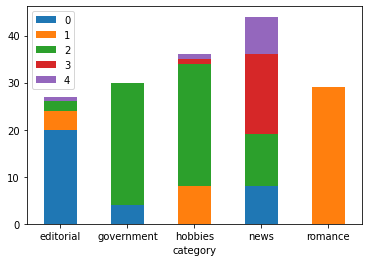

In [73]:
df.groupby(['category', 'pred_topic_num']).size().unstack().plot(kind='bar', stacked=True, rot=0).legend(loc='best')
#This fast stacked bar courtesy of:
#https://stackoverflow.com/questions/34917727/stacked-bar-plot-by-grouped-data-with-pandas

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Overall, the results are explainable, and the topic areas appear to overlap somewhat with the Brown topics.

Topic 0 seems very "news" oriented. Mostly assigned to "editorial", and the next biggest bunch to "news".

Topic 1 is pretty generic.  Assigned mainly to "romance"

Topic 2 seems related to governmnet, states, etc.  Most of the "government" articles got this assignmnet, but still lots of spillover of topic 2 into "hobbies" and "news".  This topic had the most overlap, and the relationship to "hobbies" is hard to discern.

Topic 3 has Mr., Mrs. Ms. at the top.  Many news articles refer formally to people so this is not surprising.

Topic 4 is all about sports.  Again, mostly included in the "news" articles.  About 1/4 of news in the old days was sports driven.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [74]:
from sklearn.decomposition import TruncatedSVD

svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

### Relative Sizes of the Topics

In [75]:
svd_text_model.singular_values_

array([3.69734343, 2.24163352, 1.69712548, 1.66355215, 1.56267787])

In [76]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (4.32)
  didn (2.89)
  thought (2.43)
  mrs (2.18)
  got (2.16)

Topic 02
  mrs (3.11)
  mr (1.72)
  said (1.02)
  kennedy (0.80)
  president (0.77)

Topic 03
  mrs (27.75)
  club (6.23)
  game (6.17)
  jr (5.32)
  dallas (5.10)

Topic 04
  game (4.45)
  league (3.16)
  baseball (3.13)
  ball (3.03)
  team (2.88)


In [77]:
# Transform the new data with the fitted models
svd_X_vecs = svd_text_model.transform(tfidf_text_vectors)
#
#
#PROBLEM HERE?  Why is the model predicting so many Topic 00?
#
# Compare with the original X processing (they're the same)
#svd_X_vecs
W_svd_text_matrix[0:5]

array([[ 0.39115169, -0.24737234, -0.01756635, -0.0556066 , -0.00310002],
       [ 0.36463326, -0.234189  ,  0.20550987, -0.26883501,  0.1538794 ],
       [ 0.37909785, -0.13375835,  0.15135919, -0.21261316,  0.09417838],
       [ 0.38083049, -0.22871365,  0.10516468, -0.17244089,  0.08051759],
       [ 0.36099295, -0.20911359,  0.04006986, -0.08537837,  0.01840441]])

In [78]:
# Get the top predicted topic
svd_predicted_topics = [np.argsort(each)[::-1][0] for each in svd_X_vecs]
#SVD_predicted_topics = [np.argsort(abs(each))[::-1][0] for each in SVD_X_new]

In [79]:
# Add to the df
df['svd_pred_topic_num'] = svd_predicted_topics
df.tail(5)

,category,id,text,char_len,word_len,pred_topic_num,svd_pred_topic_num
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339,2,0
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233,2,0
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,2,0
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,2,0
165,hobbies,ce36,There comes a time in the lives of most of us ...,11682,2232,2,0


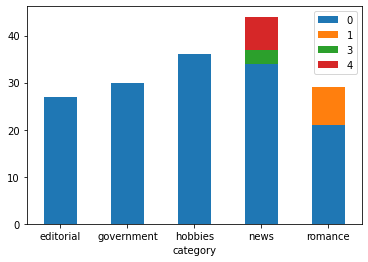

In [80]:
df.groupby(['category', 'svd_pred_topic_num']).size().unstack().plot(kind='bar', stacked=True, rot=0).legend(loc='best')
#This fast stacked bar courtesy of:
#https://stackoverflow.com/questions/34917727/stacked-bar-plot-by-grouped-data-with-pandas

Q: What is your interpretation of the display topics output? 

A: There are some discernable differences in the topics, but only topic 4 is different in a pronounced way, containing sports items.  Many of the topics contain the same tokens, especially "mr", "mrs", and "said".  Looking at performance, this model creates topics that are not representaive of the Brown topics, as well as failing to capture much, if any, of the differences between the topics.  Interesting result since the textbook application of LSA obtained a very similar result to NME, and both techniques are derived from linear algebra decomposition of the orginal document matrix.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [81]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [82]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  house (0.69)
  clay (0.60)
  shelter (0.47)
  inch (0.46)
  cut (0.45)

Topic 01
  said (1.24)
  man (0.58)
  old (0.55)
  little (0.54)
  good (0.49)

Topic 02
  feed (1.07)
  af (0.74)
  pool (0.55)
  head (0.45)
  high (0.43)

Topic 03
  state (0.83)
  states (0.59)
  united (0.53)
  government (0.49)
  000 (0.41)

Topic 04
  mrs (1.51)
  said (1.06)
  mr (0.84)
  home (0.67)
  week (0.51)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: These topics appear less differentiated than the NME topics but better than the LSA topics.  One can see some similarlity in topic 0 ("building" or "hobbies"), topic 2 (af, pool, feed = "hobbies"?), topic 03 ("governement"?), and topic 4 (mr and mrs indicating "news" perhaps).  Topic 1 is generic but, as seen below, largely represents the "romance" category from Brown.

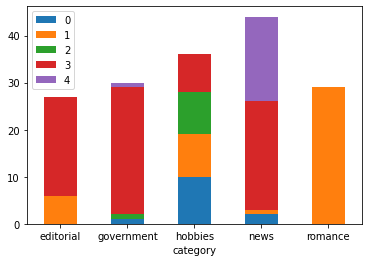

In [83]:
# Transform the new data with the fitted models
lda_X_vecs = lda_text_model.transform(tfidf_text_vectors)

# Get the top predicted topic
lda_pred_topics = [np.argsort(each)[::-1][0] for each in lda_X_vecs]

# Add to the df
df['lda_pred_topic_num'] = lda_pred_topics
df.head(5)

df.groupby(['category', 'lda_pred_topic_num']).size().unstack().plot(kind='bar', stacked=True, rot=0).legend(loc='best')
#This fast stacked bar courtesy of:
#https://stackoverflow.com/questions/34917727/stacked-bar-plot-by-grouped-data-with-pandas

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Overall, the results are explainable and overlapping as for NME, but the topic areas are different.  There is no sports-oriented topic.  And instead of 2 fairly distinct topics for news and government topics, there was only one. There also seemed to be a topic that captured "hobbies" a bit better than NME.

Topic 0 seems about houses, building, shelter. Mostly assigned to "hobbies" which seems plausible.

Topic 1 is fairly generic but novelesque.  Assigned mainly to "romance" and "hobbies".  Makes sense.

Topic 2 is a bit of a hodgepodge.  Also mostly in the "hobbies" category.

Topic 3 is the newsy topic, and unsurprisingly comprise most of the "news", "government", and "editorial" articles.

Topic 4 has Mr. and Mrs. as did NME.  Again, mostly included in the "news" articles.

In [84]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\drzag\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\drzag\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [85]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The low dimensional projection (and non-overlapping separation) of the topics reinforces the resonable topic separation noted by examining the words in the topics.  The length of the red bars decreases most rapidly for Bubble 4 (which is topic 3, our newsy/government topic), and Bubble 5 (which is topic 4, our mr, mrs, news topic).  This was seen in the mapping to Brown topics: topics 3/4 were almost entirely restricted to the news/governement/editorial Brown categories.  Topics 0, 1 and 2 are less defined and made up articles from the more heterogeneous categories of "hobbies", "romance", and also "editorials".
